In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupShuffleSplit
from math import sqrt
from sklearn.ensemble import RandomForestRegressor


In [2]:
df = pd.read_excel("C:\\Users\\10535\\Desktop\\text 7.3\\nonMOF1205.xls")
df.head()
df['SSA(m2/g)'] = pd.to_numeric(
    df['SSA(m2/g)'].astype(str).str.strip().str.replace(r'[^\d.]', '', regex=True), 
    errors='coerce'
)
df['TPV(cm3/g)'] = pd.to_numeric(
    df['TPV(cm3/g)'].astype(str).str.strip().str.replace(r'[^\d.]', '', regex=True), 
    errors='coerce'
)
# Checking cleaned results and data types
print("Cleaned SSA(m2/g) first few rows:")
print(df['SSA(m2/g)'].head())
print("\nCleaned TPV(cm3/g) first few rows:")
print(df['TPV(cm3/g)'].head())
print("\nCleaned data types:")
print(df[['SSA(m2/g)', 'TPV(cm3/g)']].dtypes)
# Checking for missing values (NaN)
print("\nMissing values statistics:")
print(df[['SSA(m2/g)', 'TPV(cm3/g)']].isnull().sum())
# Saving cleaned data to a new Excel file
output_file_path = 'cleaned_nonMOF1205non.xls'
df.to_excel(output_file_path, index=False, engine='openpyxl')
print(f"Cleaned dataset saved as {output_file_path}")

Cleaned SSA(m2/g) first few rows:
0     805.0
1     805.0
2     805.0
3    2471.0
4    2471.0
Name: SSA(m2/g), dtype: float64

Cleaned TPV(cm3/g) first few rows:
0    0.49
1    0.49
2    0.49
3    1.20
4    1.20
Name: TPV(cm3/g), dtype: float64

Cleaned data types:
SSA(m2/g)     float64
TPV(cm3/g)    float64
dtype: object

Missing values statistics:
SSA(m2/g)     0
TPV(cm3/g)    0
dtype: int64
Cleaned dataset saved as cleaned_nonMOF1205non.xls


In [3]:
statistics = df.describe().transpose()
missing_data_percentage = (df.isnull().mean() * 100).round(2)
result = pd.DataFrame()
result['Mean'] = statistics['mean']
result['Std. deviation'] = statistics['std']
result['Min'] = statistics['min']
result['25% percentile'] = statistics['25%']
result['50% percentile'] = statistics['50%']
result['75% percentile'] = statistics['75%']
result['Max'] = statistics['max']
result['% Missing data'] = missing_data_percentage
print(result)

                                          Mean  Std. deviation     Min  \
Metal oxidation state                 2.472477        0.666288    2.00   
Electronegativity                     1.714037        0.193855    1.31   
Synthesis temperature               421.348624       39.484320  353.00   
Synthesis time                       28.587798       26.938597    0.16   
Activation temperature              459.513761       54.871045  298.00   
coordination number                   6.146789        1.622569    2.00   
Pore channel type1                    2.380734        1.346439    1.00   
Pore channel type2                    1.389908        0.488852    1.00   
Pore channel type3                    1.972477        0.954820    1.00   
Pore channel type4                    2.151376        0.831424    1.00   
Thermal decomposition temperature   315.160550       85.960804  200.00   
SSA(m2/g)                          1650.567294      722.568200   31.00   
TPV(cm3/g)                            

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
label_cols = ['Center metal', 'Ligand', 'Space group','Topology type','geometry']
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [5]:
plt.rcParams['font.family'] = 'Times New Roman'
x = df.drop(columns=['CO uptake\n(mmol/g)'])
y = df['CO uptake\n(mmol/g)']
groups = df['SSA(m2/g)']
# Creating GroupShuffleSplit instance
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(x, y, groups):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# Checking results
print("Training set size:", x_train.shape, y_train.shape)
print("Test set size:", x_test.shape, y_test.shape)

Training set size: (166, 20) (166,)
Test set size: (52, 20) (52,)


In [12]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}


model = XGBRegressor(seed=42) 


grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2  
)

grid_search.fit(x_train, y_train)
print(f"Best hyperparameters: {grid_search.best_params_}")
model4 = XGBRegressor(**grid_search.best_params_)
model4.fit(x_train, y_train)

y_predicted = model4.predict(x_test)

print("Training set R2: %.4f" % model4.score(x_train, y_train))
print("Test set R2: %.4f" % model4.score(x_test, y_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_predicted))
print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_predicted)))
print("MAE: %.4f" % mean_absolute_error(y_test, y_predicted))

accuracies = cross_val_score(estimator=model4, X=x_train, y=y_train, cv=5)
print("The mean training accuracy is: %.4f" % accuracies.mean())

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.5; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END

<Figure size 1000x800 with 0 Axes>

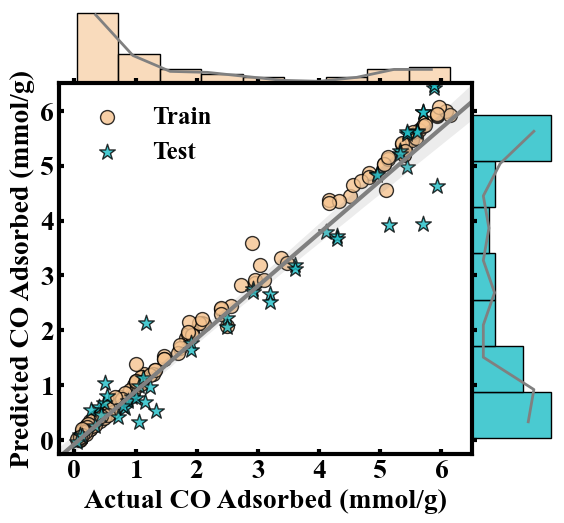

In [13]:
y_predicted = model4.predict(x_test)
pp_tr = model4.predict(x_train)
plt.figure(figsize=(10, 8))
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'bold'
train_color = "#F6C490"  
test_color = "#1DBDC6"   
reg_line_color = "gray"  
train_marker = 'o'      
test_marker = '*'       

g = sns.JointGrid(x=y_test, y=y_predicted, space=0)

sns.scatterplot(x=y_train, y=pp_tr, color=train_color, edgecolor="k", marker=train_marker,
                s=100, alpha=0.8, linewidth=1, ax=g.ax_joint, label='Train')

sns.scatterplot(x=y_test, y=y_predicted, color=test_color, edgecolor="k", marker=test_marker,
                s=140, alpha=0.8, linewidth=1, ax=g.ax_joint, label='Test')

g.ax_joint.set_xlim(-0.25, 6.5)
g.ax_joint.set_ylim(-0.25, 6.5)
g.ax_joint.set_xticks(np.arange(0, 7, 1))
g.ax_joint.set_yticks(np.arange(0, 7, 1))

sns.regplot(x=y_test, y=y_predicted, ax=g.ax_joint, scatter=False, 
            color=reg_line_color, line_kws={"linewidth": 3}, x_bins=20, truncate=False)

sns.histplot(x=y_train, ax=g.ax_marg_x, color=train_color, edgecolor="k", alpha=0.6, label='Train')
hist, bins = np.histogram(y_train)
bin_centers = (bins[:-1] + bins[1:]) / 2
g.ax_marg_x.plot(bin_centers, hist, color="gray", linewidth=2)

sns.histplot(y=y_test, ax=g.ax_marg_y, color=test_color, edgecolor="k", alpha=0.8, label='Test')
hist, bins = np.histogram(y_test)
bin_centers = (bins[:-1] + bins[1:]) / 2
g.ax_marg_y.plot(hist, bin_centers, color="gray", linewidth=2)
# Setting axis labels
g.set_axis_labels("Actual CO Adsorbed (mmol/g)", "Predicted CO Adsorbed (mmol/g)", 
                 fontsize=20, fontweight='bold')
for ax in [g.ax_joint, g.ax_marg_x, g.ax_marg_y]:
    ax.tick_params(axis='both', which='major', width=3, direction='in', labelsize=20)
    for spine in ax.spines.values():
        spine.set_linewidth(3)

leg = g.ax_joint.legend(['Train', 'Test'], frameon=False, 
                       fontsize=18, loc='upper left')
for text in leg.get_texts():
    text.set_weight('bold')
plt.show()

In [14]:
param_grid = {
     'n_estimators': [50, 100, 200],  
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1,2, 3, 4],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'subsample': [0.6, 0.8, 1.0],
}

model = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5,  
    verbose=2  
)

grid_search.fit(x_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

model1 = GradientBoostingRegressor(**grid_search.best_params_)

model1.fit(x_train, y_train)


y_predicted = model1.predict(x_test)

print("Training set R2: %.4f" % model1.score(x_train, y_train))
print("Test set R2: %.4f" % model1.score(x_test, y_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_predicted))
print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_predicted)))

print("MAE: %.4f" % mean_absolute_error(y_test, y_predicted))

accuracies = cross_val_score(estimator=model1, X=x_train, y=y_train, cv=5)
print("The mean training accuracy is: %.4f" % accuracies.mean())

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.6; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END learning_rate=0.05, max_depth=1, min_samples_leaf=3, min_samples_split=5, n_estimators=50, subsample=0.8; total time=   0.0

In [15]:
# Training and Evaluation of Extreme Random Tree Regression Model
from sklearn.ensemble import ExtraTreesRegressor
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500], 
    'max_depth': [3, 5, 7], 
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 5]  
}

model = ExtraTreesRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2  
)


grid_search.fit(x_train, y_train)


print(f"Best hyperparameters: {grid_search.best_params_}")


model3 = ExtraTreesRegressor(**grid_search.best_params_)

model3.fit(x_train, y_train)

y_predicted = model3.predict(x_test)

print("Training set R2: %.4f" % model3.score(x_train, y_train))
print("Test set R2: %.4f" % model3.score(x_test, y_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_predicted))
print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_predicted)))
print("MAE: %.4f" % mean_absolute_error(y_test, y_predicted))

accuracies = cross_val_score(estimator=model3, X=x_train, y=y_train, cv=5)
print("The mean training accuracy is: %.4f" % accuracies.mean())

Fitting 3 folds for each of 135 candidates, totalling 405 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END max_depth=3, min_samples_lea

In [16]:
# Training and Evaluation of Random Forest Regression Model
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None] 
}
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2
)
grid_search.fit(x_train, y_train)
print(f"Best hyperparameters: {grid_search.best_params_}")
model2 = RandomForestRegressor(**grid_search.best_params_, random_state=42)
model2.fit(x_train, y_train)
y_predicted = model2.predict(x_test)
print("Training set R2: %.4f" % model2.score(x_train, y_train))
print("Test set R2: %.4f" % model2.score(x_test, y_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_predicted))
print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_predicted)))

print("MAE: %.4f" % mean_absolute_error(y_test, y_predicted))

accuracies = cross_val_score(estimator=model2, X=x_train, y=y_train, cv=5)
print("The mean training accuracy is: %.4f" % accuracies.mean())

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200

In [17]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 1, 3]
}

model = SVR()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=3,  
    verbose=2  
)

grid_search.fit(x_train, y_train)


print(f"Best hyperparameters: {grid_search.best_params_}")
model7 = SVR(**grid_search.best_params_)
model7.fit(x_train, y_train)

y_predicted = model7.predict(x_test)

print("Training set R2: %.4f" % model7.score(x_train, y_train))
print("Test set R2: %.4f" % model7.score(x_test, y_test))
print("MSE: %.4f" % mean_squared_error(y_test, y_predicted))
print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_predicted)))
print("MAE: %.4f" % mean_absolute_error(y_test, y_predicted))


accuracies = cross_val_score(estimator=model7, X=x_train, y=y_train, cv=3)
print("The mean training accuracy is: %.4f" % accuracies.mean())

Fitting 3 folds for each of 112 candidates, totalling 336 fits
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, epsilon=0.1, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, epsilon=0.1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, epsilon=0.1, kernel=rbf; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.1, kernel=sigmoid; total time=   0.0s
[CV] END .................C=0.1, epsilon=0.1, 